# Revisiting midpoints
> Were my midpoint assumptions mistaken in the hyperDT paper?

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from hyperdt.hyperbolic_trig import get_midpoint
from geomstats.geometry.hyperboloid import Hyperboloid

## Confirm initial midpoint correctness

The `get_midpoint` function implements the midpoint computation from the hyperDT paper.

First things first, we should verify that:
* The point $\sqrt{-\sec(2\theta)}$ actually puts you on the hyperboloid
* For sparse vectors defined as $\langle \alpha\sin(\theta), \ldots, \alpha\cos(\theta)$, their midpoaint is:
  * Equidistant
  * On the hyperboloid

In [3]:
# Things we will reuse
H = Hyperboloid(dim=2)
thetas = np.linspace(np.pi / 4 + 0.05, 3 * np.pi / 4 - 0.05, 100)

In [4]:
# Confirm point on hyperboloid
def angle_coef(theta: float) -> float:
    """alpha(theta, K) = sqrt(-sec(2theta) / K)"""
    return np.sqrt(-1 / np.cos(2 * theta))


def angle_to_hyperboloid(theta: float, dims: int = 2) -> np.ndarray:
    return angle_coef(theta) * np.array([np.sin(theta), np.cos(theta)] + [0] * (dims - 1))


for theta in thetas:
    point = angle_to_hyperboloid(theta)
    assert H.belongs(point)

This next cell uncovers* an interesting imbalance when $\theta_1 + \theta_2 \approx \pi$, likely due to some numerical issues

* = uncover/ed/; we have added a patch to `_hyperbolic_midpoint` to fix this.

In [9]:
# Confirm midpoint properties
results_belongs = np.zeros((len(thetas), len(thetas)))
results_dist = np.zeros((len(thetas), len(thetas)))
for i, theta1 in enumerate(thetas):
    for j, theta2 in enumerate(thetas):
        midpoint = get_midpoint(theta1, theta2)
        p1 = angle_to_hyperboloid(theta1)
        p2 = angle_to_hyperboloid(theta2)
        p_mid = angle_to_hyperboloid(midpoint)
        results_belongs[i, j] = H.belongs(p_mid)
        results_dist[i, j] = np.isclose(H.metric.dist(p1, p_mid), H.metric.dist(p2, p_mid))
        if not results_belongs[i, j]:
            print(theta1 + theta2)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(results_belongs, cmap='gray')
# axs[0].set_title('Belongs')
# axs[1].imshow(results_dist, cmap='gray')
# axs[1].set_title('Dist')

## Midpoint behavior further along the geodesic

We have shown now that the hyperplanes paramterized by $\theta_1$ and $\theta_2$ are equidistant to the midpoint $\theta_m$ when all other dimensions are zero. What if we relax this assumption?

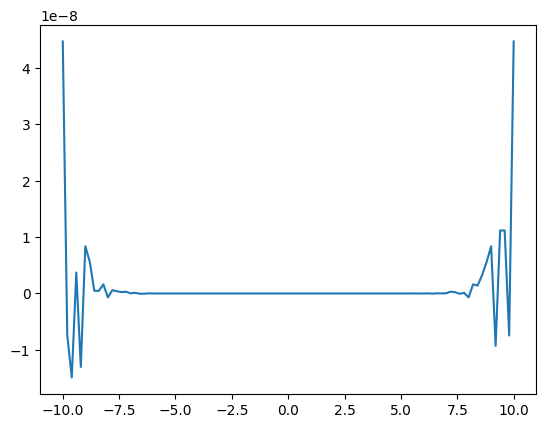

In [86]:
# Check that the formula for geodesics we use is correct:
# Let u be a unit vector orthogonal to v
# Let v = [sin(theta), cos(theta), 0]
# geodesic is given by p(t) = cosh(t) * alpha(theta) * v + sinh(t) * u


def mnorm(p):
    return (p[1:] ** 2).sum() - p[0] ** 2


# Set some thetas
theta1 = np.pi / 4 + 0.05
theta2 = np.pi / 2
midpoint = get_midpoint(theta1, theta2)

# Get the alphas
alpha1 = angle_coef(theta1)
alpha2 = angle_coef(theta2)
alpha_mid = angle_coef(midpoint)

# Get all the other stuff we need
origin = np.array([1, 0, 0])
u = np.array([0, 0, 1])
v1 = np.array([np.sin(theta1), np.cos(theta1), 0])
v2 = np.array([np.sin(theta2), np.cos(theta2), 0])
v_mid = np.array([np.sin(midpoint), np.cos(midpoint), 0])

# Measure distances along the geodesic
dists = []
vals = np.linspace(-10, 10, 101)
for t in vals:
    p1 = np.cosh(t) * alpha1 * v1 + np.sinh(t) * u
    p2 = np.cosh(t) * alpha2 * v2 + np.sinh(t) * u
    p_mid = np.cosh(t) * alpha_mid * v_mid + np.sinh(t) * u
    # print(mnorm(p1), mnorm(p2), mnorm(p_mid))

    # assert H.belongs(p1, atol=1e-3)
    # assert H.belongs(p2, atol=1e-3)
    # assert H.belongs(p_mid, atol=1e-3)

    dists.append(H.metric.dist(p1, p_mid) - H.metric.dist(p2, p_mid))

plt.plot(vals, dists)

OK, this is really interesting! It looks like we actually preserve equidistance no matter where we are on the origin. That's nice...

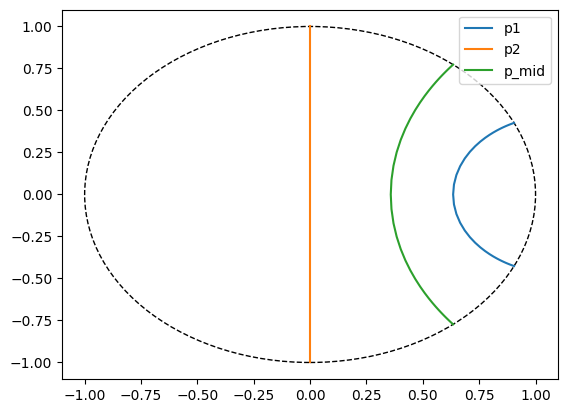

In [93]:
# Let's plot these coordinates in the Poincare disk
def to_poincare_disk(p):
    return p[1:] / (p[0] + 1)


p1_coords = []
p2_coords = []
p_mid_coords = []
for t in np.linspace(-10, 10, 101):
    p1 = np.cosh(t) * alpha1 * v1 + np.sinh(t) * u
    p1_coords.append(to_poincare_disk(p1))
    p2 = np.cosh(t) * alpha2 * v2 + np.sinh(t) * u
    p2_coords.append(to_poincare_disk(p2))
    p_mid = np.cosh(t) * alpha_mid * v_mid + np.sinh(t) * u
    p_mid_coords.append(to_poincare_disk(p_mid))

p1_coords = np.array(p1_coords)
p2_coords = np.array(p2_coords)
p_mid_coords = np.array(p_mid_coords)

plt.plot(p1_coords[:, 0], p1_coords[:, 1], label="p1")
plt.plot(p2_coords[:, 0], p2_coords[:, 1], label="p2")
plt.plot(p_mid_coords[:, 0], p_mid_coords[:, 1], label="p_mid")

# Draw poincare disk
circle = plt.Circle((0, 0), 1, fill=False, color="black", linestyle="--")
ax = plt.gca()
ax.add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.legend()

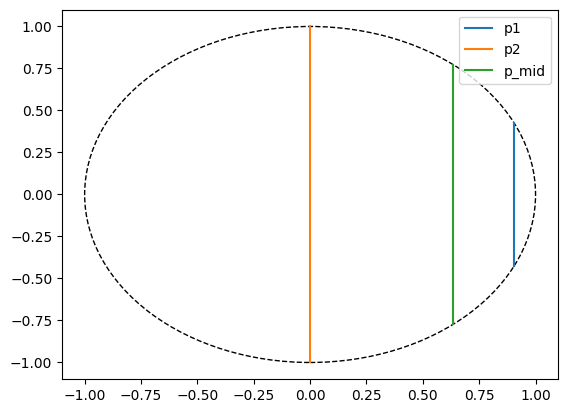

In [ ]:
# Do the same thing in the Klein disk


def to_klein_disk(p):
    return p[1:] / p[0]


p1_coords = []
p2_coords = []
p_mid_coords = []

for t in np.linspace(-10, 10, 101):
    p1 = np.cosh(t) * alpha1 * v1 + np.sinh(t) * u
    p1_coords.append(to_klein_disk(p1))
    p2 = np.cosh(t) * alpha2 * v2 + np.sinh(t) * u
    p2_coords.append(to_klein_disk(p2))
    p_mid = np.cosh(t) * alpha_mid * v_mid + np.sinh(t) * u
    p_mid_coords.append(to_klein_disk(p_mid))

p1_coords = np.array(p1_coords)
p2_coords = np.array(p2_coords)
p_mid_coords = np.array(p_mid_coords)

plt.plot(p1_coords[:, 0], p1_coords[:, 1], label="p1")
plt.plot(p2_coords[:, 0], p2_coords[:, 1], label="p2")
plt.plot(p_mid_coords[:, 0], p_mid_coords[:, 1], label="p_mid")

# Draw klein disk
circle = plt.Circle((0, 0), 1, fill=False, color="black", linestyle="--")
ax = plt.gca()
ax.add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.legend()

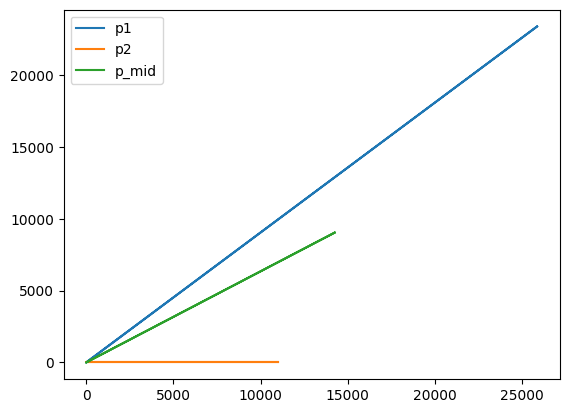

In [96]:
# And just for good measure, let's plot the first 2 dimensions of the hyperboloid

p1_coords = []
p2_coords = []
p_mid_coords = []

for t in np.linspace(-10, 10, 101):
    p1 = np.cosh(t) * alpha1 * v1 + np.sinh(t) * u
    p1_coords.append(p1[:2])
    p2 = np.cosh(t) * alpha2 * v2 + np.sinh(t) * u
    p2_coords.append(p2[:2])
    p_mid = np.cosh(t) * alpha_mid * v_mid + np.sinh(t) * u
    p_mid_coords.append(p_mid[:2])

p1_coords = np.array(p1_coords)
p2_coords = np.array(p2_coords)
p_mid_coords = np.array(p_mid_coords)

plt.plot(p1_coords[:, 0], p1_coords[:, 1], label="p1")
plt.plot(p2_coords[:, 0], p2_coords[:, 1], label="p2")
plt.plot(p_mid_coords[:, 0], p_mid_coords[:, 1], label="p_mid")

# # Draw klein disk
# circle = plt.Circle((0, 0), 1, fill=False, color="black", linestyle="--")
# ax = plt.gca()
# ax.add_artist(circle)
# plt.xlim(-1.1, 1.1)
# plt.ylim(-1.1, 1.1)
plt.legend()

## The same thing with Einstein midpoints

In [ ]:
# there is no good Klein model, so we'll have to do it ourselves
# we already have to_klein_disk to get coordinates
# what we're interested in is the klein midpoint - we can compose to_klein_disk, get_midpoint, angle_to_hyperboloid

theta1 = np.pi / 4 + 0.05
theta2 = np.pi / 2

# Get the midpoint
midpoint = get_midpoint(theta1, theta2)


def get_angle(p):
    """Get the angle of a point in the Klein disk model"""
    factor = 1 / np.sqrt(1 + np.sum(p**2))
    return np.arctan2(p[0] * factor, p[1] * factor)


# Get the klein midpoint
p1 = angle_to_hyperboloid(theta1)
p2 = angle_to_hyperboloid(theta2)
p_mid = angle_to_hyperboloid(midpoint)

# Check that the angles are still well-behaved
assert np.allclose(get_angle(p1), theta1)
assert np.allclose(get_angle(p2), theta2)
assert np.allclose(get_angle(p_mid), midpoint)


# Compute the Einstein midpoint of two points
# Taken from hyperdt/faster_tree.py
def _einstein_midpoint(u, v):
    """Einstein midpoint for scalar features. Assumes u, v are the i-th coordinates of points in the Klein model"""
    gamma_u = 1 / np.sqrt(1 - u**2)
    gamma_v = 1 / np.sqrt(1 - v**2)

    # Correct Einstein midpoint formula for scalars
    numerator = gamma_u * u + gamma_v * v
    denominator = gamma_u + gamma_v
    midpoint = numerator / denominator

    # Rescale back to original coordinates
    return midpoint


# Is it the same?
# First, convert to Klein and check that our coordinates are sparse
p1_klein = to_klein_disk(p1)
p2_klein = to_klein_disk(p2)
p_mid_klein = to_klein_disk(p_mid)
assert p1_klein[1] == 0
assert p2_klein[1] == 0
assert p_mid_klein[1] == 0

# Now, compute the Einstein midpoint
p_mid_einstein = np.array([_einstein_midpoint(p1_klein[0], p2_klein[0]), 0])
assert np.allclose(p_mid_einstein, p_mid_klein)


# Finally, convert back to hyperboloid and check that the angles are still well-behaved
def klein_to_hyperboloid(p):
    norm_squared = np.sum(p**2)
    factor = 1 / np.sqrt(1 - norm_squared)
    hyperboloid_coords = np.concatenate(([factor], p * factor))
    return hyperboloid_coords


p_mid_hyperboloid = klein_to_hyperboloid(p_mid_einstein)
assert np.allclose(get_angle(p_mid_hyperboloid), midpoint)